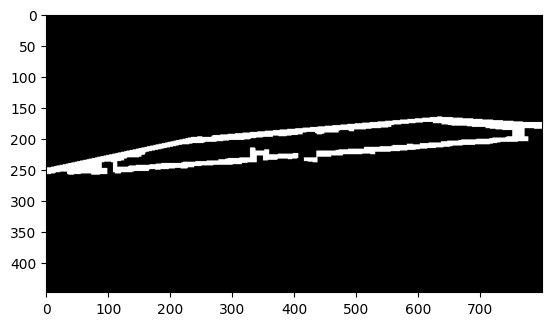

In [105]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_name = "025-rgb.png"

img = cv2.imread("../data/log1/" + image_name)
plt.imshow(img)

mask = cv2.imread("../data/mask-field/log1/" + image_name, cv2.IMREAD_GRAYSCALE)

def preprocess(image, mask):

    def filter_pixels(image, red_threshold=120, blue_threshold=100):
        """
            Filter out pixels that are too blue or too red

            :param image: Image to filter (BGR)

            :return: Filtered image (BGR)
        """
        blue_channel = image[:, :, 0]
        red_channel = image[:, :, 2]

        image[(red_channel > red_threshold) & (blue_channel > blue_threshold)] = [0, 0, 0]

        return image
    
    def remove_noise(image):
        """
            Try to remove noise from the image

            :param image: Image to remove noise from (GRAYSCALE)

            :return: Image with noise removed (GRAYSCALE)
        """

        horizontal_kernel = (3, 1)

        for _ in range(2):
            image = cv2.GaussianBlur(image, horizontal_kernel, 1)
            _, image = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)


        square_kernel = np.ones((2, 2))

        image = cv2.erode(image, square_kernel, iterations=2)
        image = cv2.dilate(image, square_kernel, iterations=3)

        return image
    
    image_filtered = filter_pixels(image)
    image_filtered_grayscale = cv2.cvtColor(image_filtered, cv2.COLOR_BGR2GRAY)
    image_masked = cv2.bitwise_and(image_filtered_grayscale, mask)

    image_thresholded = cv2.adaptiveThreshold(image_masked, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
    image_denoised = remove_noise(image_thresholded)

    return image_denoised


def detect_corners(image):
    """
        Detect corners in the image

        :param image: Image to detect corners in (GRAYSCALE)

        :return: Edges of the image (GRAYSCALE)
    """
    low_threshold = 100
    high_threshold = 255
    edges = cv2.Canny(image, low_threshold, high_threshold)

    return edges
    

def get_image_lines(image, edges):
    """
        Get the lines in the image using probabilistic Hough transform

        :param image: Image to get lines from (GRAYSCALE)

        :return: Lines detected in the image, Image with lines (GRAYSCALE)
    """
    rho = 2  # Distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # Angular resolution of the Hough grid
    threshold = 50  # Minimum number of votes
    min_line_length = 100  # Minimum number of pixels for a line
    max_line_gap = 20  # Maximum gap in pixels between connectable line segments
    line_image = np.copy(image) * 0 

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    lines = np.squeeze(lines)

    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 255, 255), 5)

    return lines, line_image

def get_lines_angle(lines):
    angles = {}

    for line in lines:
        x1, y1, x2, y2 = line
        angle = round(np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi)

        if angle not in angles:
            angles[angle] = 1
        else:
            angles[angle] += 1

    return max(angles, key=angles.get)


image_denoised = preprocess(img, mask)
edges = detect_corners(image_denoised)
lines, line_image = get_image_lines(image_denoised, edges)
angle = get_lines_angle(lines)

# Use the lines to mask the image
img = cv2.bitwise_and(image_denoised, line_image)

# Make a 5x5 image of a cross with the same angle
cross = np.zeros((5, 5), dtype=np.uint8)
cross[2, :] = 255
cross[:, 2] = 255
cross = cv2.rotate(cross, angle)

img = cv2.dilate(img, cross, iterations=6)
img = cv2.erode(img, cross, iterations=4)

plt.imshow(img, cmap="gray")
plt.show()